#### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import time
import os
import random
import shutil

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


#### Dataset

https://www.kaggle.com/drgfreeman/rockpaperscissors

Classes: Rock, paper and scissors

#### Data augmentation

Five images were generated for each of the images in all classes

In [2]:
# definir caminhos da imagem original e diretório do output
IMAGE_PATH = "../work/data/train/"
OUTPUT_PATH = "../work/data/train/"
label_classes = os.listdir(IMAGE_PATH)
print(label_classes)

len_itens_per_class = []
for i in label_classes:
    len_itens_per_class.append(len(os.listdir(IMAGE_PATH + i)))

print(len_itens_per_class)

['paper', 'rock', 'scissors']
[569, 580, 600]


In [3]:
def show_duration(dur):
    if dur<60:
        print("Execution Time:", dur, "seconds")
    elif dur>60 and dur<3600:
        dur=dur/60
        print("Execution Time:", dur, "minutes")
    else:
        dur=dur/(60*60)
        print("Execution Time:", dur, "hours")

In [4]:
def plot_pizza(label_classes, len_itens_per_class):
    plt.figure(figsize=(6,6))
    explode = (0, 0, 0)
    plt.pie(len_itens_per_class, labels=label_classes ,  autopct='%1.1f%%', explode=explode)
    plt.savefig('../work/pie.jpg')
    plt.show()

def plot_hist(len_itens_per_class):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(5, 4))
    # input data
    mean_values = len_itens_per_class
    variance = [1,2,3]#[0.2, 0.4, 0.5]
    bar_labels = label_classes

    fig = plt.gca()

    # plot bars
    x_pos = list(range(len(bar_labels)))
    plt.bar(x_pos, mean_values, align='center', alpha=0.5)

    # set height of the y-axis
    max_y = max(zip(mean_values, variance)) # returns a tuple, here: (3, 5)
    plt.ylim([0, (max_y[0] + max_y[1]) * 1.1])

    # set axes labels and title
    plt.ylabel('Quantidade de instâncias')
    plt.xticks(x_pos, bar_labels)
    plt.title('Classes')
    plt.savefig('../work/hist.jpg')
    plt.show()

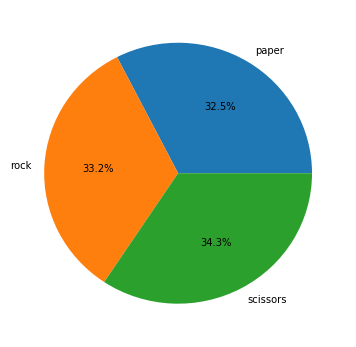

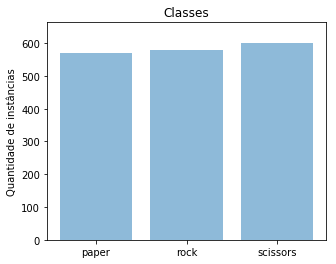

In [5]:
plot_pizza(label_classes, len_itens_per_class)
print('')
plot_hist(len_itens_per_class)

In [6]:
GENERATE_IMAGES = False
SPLIT_IMAGES = False

In [7]:
def data_augmentation():
    _classes = os.listdir("../work/data/train/")
    print('List of classes: ', label_classes)
    
    for cls in label_classes:
        img_path_class = IMAGE_PATH + cls + '/'
        img_path_output = OUTPUT_PATH + cls + '/'
        files = os.listdir(img_path_class)
        for j, image in enumerate(files):
            print(img_path_class + image)
            prefix = cls + 'aug_' + str((j + 1000))
            # carregar a imagem original e converter em array
            image = load_img(img_path_class + image)
            image = img_to_array(image)

            # adicionar uma dimensão extra no array
            image = np.expand_dims(image, axis=0)

            # criar um gerador (generator) com as imagens do
            # data augmentation
            imgAug = ImageDataGenerator(rotation_range=45, width_shift_range=0.2, height_shift_range=0.4, 
                                        zoom_range=0.35, fill_mode='nearest', horizontal_flip=True)
            imgGen = imgAug.flow(image, save_to_dir=img_path_output, save_format='jpg', save_prefix=prefix)

            # gerar 10 imagens por data augmentation
            counter = 0
            for (i, newImage) in enumerate(imgGen):
                counter += 1
                # ao gerar 10 imagens, parar o loop
                if counter == 5:
                    break
if GENERATE_IMAGES:                
    data_augmentation()

In [8]:
def data_split():
    # definir caminhos da imagem original e diretório do output
    IMAGE_PATH = "../work/data/train/"
    OUTPUT_PATH = "../work/data/validation/"
    
    for cls in label_classes:
        img_path_class = IMAGE_PATH + cls + '/'
        dest_path_img = OUTPUT_PATH + cls + '/'
        
        files = os.listdir(img_path_class)
        random.shuffle(files)
        random.shuffle(files)
        
        files_val = int((len(files) * 80) / 100)
        for f in files[files_val:]:
            print('Movendo de: {} | para: {}'.format(img_path_class + f, dest_path_img + f))
            shutil.move(img_path_class + f, dest_path_img + f)
            
if SPLIT_IMAGES:                                
    data_split()

##### Metrics

In [9]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

##### In summary, this is our directory structure:
```
data/
    train/
        paper/
            file.jpg
            ...
        rock/
            file.jpg
            ...
        scissors/
            file.jpg
            ...
    validation/
        paper/
            file.jpg
            ...
        rock/
            file.jpg
            ...
        scissors/
            file.jpg
            ...
```

#### Parametrization

In [10]:
start = time.time()

#epochs = 2
epochs = 30

train_data_path = '../work/data/train'
test_data_path = '../work/data/test'
validation_data_path = '../work/data/validation'

"""
Parameters
"""
img_width, img_height = 150, 150
batch_size = 64
samples_per_epoch = 500
validation_steps = 200
# nb_filters1 = 32
# nb_filters2 = 64
# nb_filters3 = 128
nb_filters1 = 32
nb_filters2 = 64
nb_filters3 = 64
nb_filters4 = 32
conv1_size = 3
conv2_size = 2
pool_size = 2
classes_num = 3
lr = 0.001

#### Model

In [11]:
def build_model():
    # Build model Keras

    _model = Sequential()
    
    # CNN 1
    _model.add(Convolution2D(nb_filters1, conv1_size, conv1_size, border_mode ="same", input_shape=(img_width, img_height, 3)))
    _model.add(Activation('relu'))
    
    # CNN 2
    _model.add(Convolution2D(nb_filters2, conv2_size, conv2_size, border_mode ="same"))
    _model.add(Activation('relu'))
    _model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    _model.add(Dropout(0.25))
    
    # CNN 3
    _model.add(Convolution2D(nb_filters3, conv1_size, conv1_size, border_mode ="same", input_shape=(img_width, img_height, 3)))
    _model.add(Activation('relu'))
    
    # CNN 4
    _model.add(Convolution2D(nb_filters4, conv1_size, conv1_size, border_mode ="same", input_shape=(img_width, img_height, 3)))
    _model.add(Activation('relu'))
    _model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
    _model.add(Dropout(0.25))
    
    # You must flatten the data for the dense layers
    _model.add(Flatten())
    
    # Dense 1
    _model.add(Dense(512, activation='relu'))
    _model.add(Dropout(0.5))
    
    # Output
    _model.add(Dense(classes_num, activation="softmax"))
    _model.compile(optimizers.rmsprop(lr=lr, decay=1e-6), loss="categorical_crossentropy", metrics=["accuracy", f1_m,precision_m, recall_m])
    
    return _model
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 64)      8256      
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 75, 75, 64)        36928     
__________

#### Dataset generation

In [12]:
data_generator = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.33)

train_generator = data_generator.flow_from_directory(
    train_data_path, 
    target_size=(img_height, img_width), 
    shuffle=True, 
    seed=13,
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size, 
    subset="training")

validation_generator = data_generator.flow_from_directory(
    train_data_path, 
    target_size=(img_height, img_width), 
    shuffle=True, 
    seed=13,
    class_mode='categorical',
    classes=label_classes,
    batch_size=batch_size, 
    subset="validation"
)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 1173 images belonging to 3 classes.
Found 576 images belonging to 3 classes.


In [13]:
# Save the best model version
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

# Save checkpoint of model
mcp_save = ModelCheckpoint('../work/data/models/mcheckpoint.h5', save_best_only=True, monitor='val_loss', mode='min')

# reduces the learning rate when the performance of the model does not progress for a certain period
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, verbose=1, epsilon=1e-4, mode='min')

H = model.fit_generator(
    train_generator,
    #samples_per_epoch=samples_per_epoch,
    steps_per_epoch=STEP_SIZE_TRAIN,
    epochs=epochs,
    validation_data=validation_generator,
    #validation_steps=validation_steps
    validation_steps=STEP_SIZE_VALID,
    workers=4,
    callbacks=[earlyStopping, mcp_save,reduce_lr_loss]
)

model.evaluate_generator(validation_generator, batch_size)

target_dir = '../work/data/models/'
if not os.path.exists(target_dir):
    os.mkdir(target_dir)
model.save(target_dir + '3_classes_model.h5')
model.save_weights(target_dir + '3_classes_weights.h5')

#Calculate execution time
end = time.time()
dur = end-start

Epoch 1/30
18/18 [==============================] - 116s 6s/step - loss: 1.8160 - acc: 0.3915 - f1_m: 0.1112 - precision_m: 0.2065 - recall_m: 0.0903 - val_loss: 1.0858 - val_acc: 0.3316 - val_f1_m: 0.3692 - val_precision_m: 0.4821 - val_recall_m: 0.3003
Epoch 2/30
18/18 [==============================] - 108s 6s/step - loss: 0.9055 - acc: 0.5764 - f1_m: 0.4536 - precision_m: 0.6365 - recall_m: 0.3946 - val_loss: 1.1734 - val_acc: 0.5000 - val_f1_m: 0.4891 - val_precision_m: 0.5078 - val_recall_m: 0.4722
Epoch 3/30
18/18 [==============================] - 109s 6s/step - loss: 0.6697 - acc: 0.7502 - f1_m: 0.7329 - precision_m: 0.7889 - recall_m: 0.6902 - val_loss: 0.4131 - val_acc: 0.8472 - val_f1_m: 0.8395 - val_precision_m: 0.8837 - val_recall_m: 0.8003
Epoch 4/30
18/18 [==============================] - 109s 6s/step - loss: 0.3573 - acc: 0.8644 - f1_m: 0.8695 - precision_m: 0.8904 - recall_m: 0.8504 - val_loss: 0.2929 - val_acc: 0.8854 - val_f1_m: 0.8862 - val_precision_m: 0.9017 - v

In [14]:
# Print duration time
show_duration(dur)

Execution Time: 38.29895861943563 minutes


#### Plot Loss and Accuracy

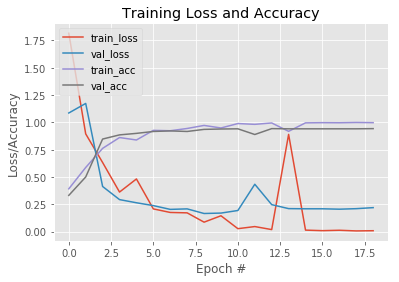

In [15]:
def plt_loss_and_accuracy():
    # plot the training loss and accuracy
    plt.style.use("ggplot")
    plt.figure()
    N = len(H.history['val_loss']) #epochs -1
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_acc"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper left")
    plt.savefig('../work/loss_acc_plt.jpg')
    plt.show()

plt_loss_and_accuracy()

#### Predict in separated dataset

In [16]:
def plot_mosaic_predictions(images_and_classes):
    
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 30),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
    plt.rcParams.update(params)
    
    plt.figure(figsize=(35, 35))
    rows = 15
    i = 0
    for img_path, label in images_and_classes:
        img = mpimg.imread(img_path)
        plt.subplot(rows, 6, i+1)
        plt.title(label, fontsize=25)
        plt.axis('off')
        plt.imshow(img)
        i = i + 1
    plt.show()

Execution Time: 3.877638816833496 seconds


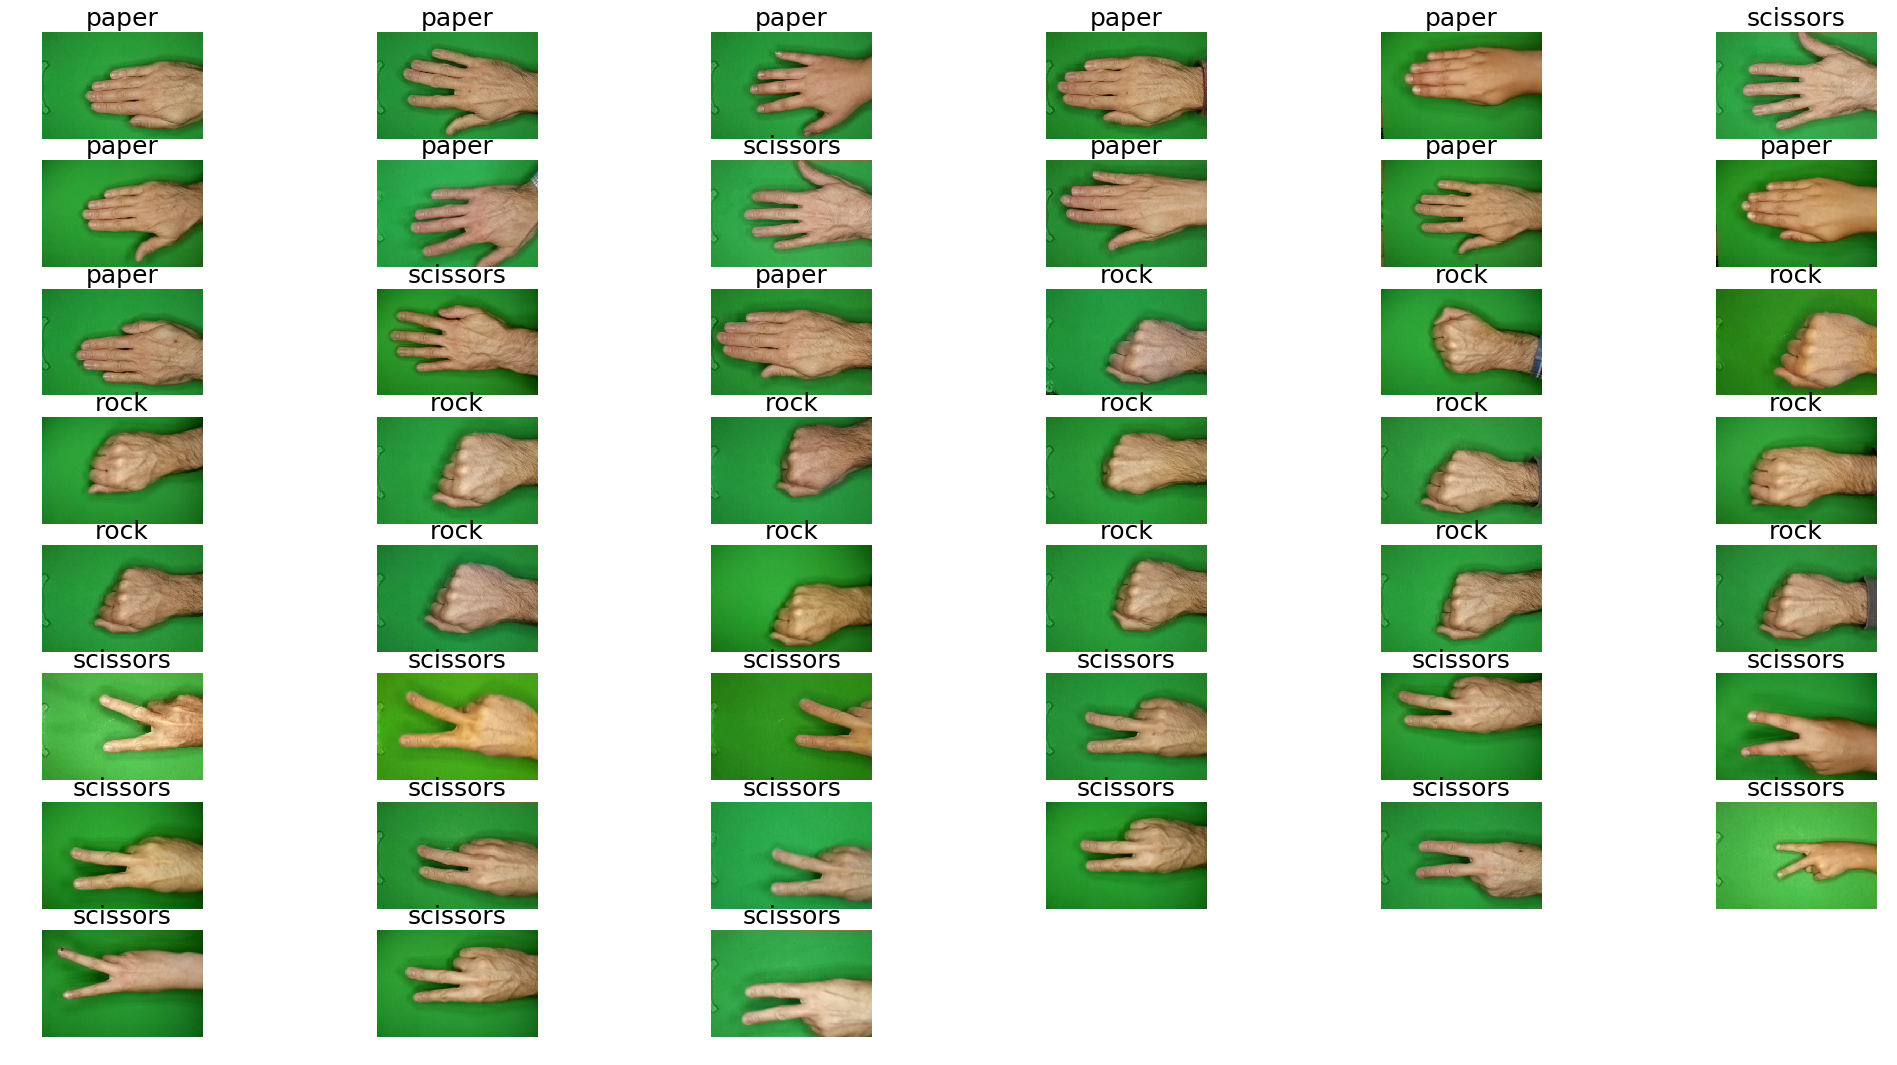

In [17]:
def test_model():
    start = time.time()

    #Define Path
    model_path = '../work/data/models/3_classes_model.h5'
    model_weights_path = '../work/data/models/mcheckpoint.h5'
    test_path = '../work/data/test/'#'../work/data/test/Faces_easy'

    # Load the pre-trained models
    model = load_model(model_path, custom_objects={
        "f1_m": f1_m,
        "precision_m": precision_m,
        "recall_m": recall_m
    })

    model.load_weights(model_weights_path)

    # Define image parameters
    img_width, img_height = 150, 150
    
    predictions = []

    # Prediction Function
    def predict(file):
        x = load_img(file, target_size=(img_width,img_height))
        x = np.expand_dims(img_to_array(x), axis=0)
        result = model.predict(x)[0]
        class_index =  np.argmax(result)
        _classes = {0: 'paper', 2: 'scissors', 1: 'rock'}
        class_pred = _classes[class_index]
        return class_pred

    # Walk the directory for every image
    for ret in os.walk(test_path):
        for i, filename in enumerate(ret[2]):
            if filename.startswith("."):
                continue
            img_path = ret[0] + '/' + filename
            result = predict(img_path)
            predictions.append((img_path, result))
    # Calculate execution time
    end = time.time()
    dur = end-start
    
    # Print duration time
    show_duration(dur)
        
    return predictions

preds = test_model()

plot_mosaic_predictions(preds)